<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [ ]:
import nltk; nltk.download('stopwords')

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# Prepare Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Import Newsgroups Data
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist(), newsgroups_train.target_names]).T
df.columns = ['content0', 'target', 'target_names']
df

In [34]:
# Remove emails and newline characters
nlp = spacy.load("en_core_web_sm")
df['content2'] = df['content0'].apply(lambda x: re.sub('\s+', ' ', x))
df['content1'] = df['content2'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))
df['content'] = df['content1'].apply(lambda x: re.sub('^a-zA-Z 0-9', '', x))
df['content']

0        I was wondering if anyone out there could enli...
1        A fair number of brave souls who upgraded thei...
2        well folks, my mac plus finally gave up the gh...
3         Do you have Weitek's address/phone number? I'...
4        From article by (Tom A Baker): My understandin...
                               ...                        
11309    DN> From: (David Nye) DN> A neurology DN> cons...
11310    I have a (very old) Mac 512k and a Mac Plus, b...
11311    I just installed a DX2-66 CPU in a clone mothe...
11312     Wouldn't this require a hyper-sphere. In 3-sp...
11313    Stolen from Pasadena between 4:30 and 6:30 pm ...
Name: content, Length: 11314, dtype: object

In [ ]:
STOP_WORDS = nlp.Defaults.stop_words.union(['-','+', '=', 'E', 'T', 'X', 'C', '  ', 'e'])

In [ ]:
# %%time
# from pandarallel import pandarallel
# Tokenize words, Clean-up text, Remove Stopwords
 # python -m spacy download en_core_web_sm

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(text) 
    tokens = []
    for token in doc:
        if ((token.pos_ in allowed_postags) and (not token.is_stop) and (token.text.lower() not in STOP_WORDS) and (token.is_punct == False) and (token.pos_ != 'PRON')):
            tokens.append(str(token))
    return tokens



In [ ]:
from tqdm import tqdm 
tqdm.pandas()

In [ ]:
# pandarallel.initialize()
# df['content'] = df['content'].parallel_apply(lambda x: lemmatization(x))
df['content'] = df['content'].progress_apply(lambda x: lemmatization(x))
df['content']


In [33]:
# Create Dictionary
id2word = corpora.Dictionary(df['content'])

# Create Corpus
texts = df['content']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]]


In [ ]:
id2word[2]

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [31]:
# Building the Topic Model
lda_model = gensim.models.ldamulticore.LdaMulticore(workers=4, 
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=15, 
                                                    random_state=100,
                                                    chunksize=100,
                                                    passes=10,
                                                    per_word_topics=True)

In [32]:
lda_model.print_topics()

[(0,
  '0.145*"X" + 0.019*"entry" + 0.016*"file" + 0.012*"program" + 0.012*"C" + 0.011*"section" + 0.010*"output" + 0.009*"T" + 0.008*"character" + 0.008*"entries"'),
 (1,
  '0.031*"o" + 0.027*"MB" + 0.020*"s" + 0.017*"font" + 0.013*"chips" + 0.012*"closed" + 0.012*"drives" + 0.011*"interface" + 0.011*"zone" + 0.010*"K"'),
 (2,
  '0.014*"know" + 0.013*"think" + 0.011*"time" + 0.010*"people" + 0.010*"good" + 0.008*"going" + 0.007*"said" + 0.007*"right" + 0.006*"way" + 0.006*"want"'),
 (3,
  '0.037*"game" + 0.034*"team" + 0.025*"games" + 0.025*"play" + 0.022*"year" + 0.021*"season" + 0.018*"players" + 0.014*"teams" + 0.013*"hockey" + 0.012*"player"'),
 (4,
  '0.014*"believe" + 0.011*"evidence" + 0.009*"true" + 0.009*"think" + 0.008*"people" + 0.007*"faith" + 0.007*"question" + 0.007*"reason" + 0.006*"point" + 0.006*"things"'),
 (5,
  '0.015*"people" + 0.007*"said" + 0.006*"children" + 0.005*"Armenian" + 0.005*"war" + 0.004*"Israeli" + 0.004*"men" + 0.004*"Turkish" + 0.004*"Jewish" + 0.00

In [30]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
topics = [' '.join(t[0:3]) for t in words]
# To make the output more readable: 
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
X file server

------ Topic 1 ------
o MB drives

------ Topic 2 ------
know think good

------ Topic 3 ------
game team play

------ Topic 4 ------
believe evidence reason

------ Topic 5 ------
people said children

------ Topic 6 ------
drive use problem

------ Topic 7 ------
available information list

------ Topic 8 ------
use patients File

------ Topic 9 ------
DoD printing strength

------ Topic 10 ------
gun space guns

------ Topic 11 ------
key people government

------ Topic 12 ------
wire jumper ground

------ Topic 13 ------
window application widget

------ Topic 14 ------
contest tests seller



In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [29]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.246476 -0.115574       1        1  19.715162
11    -0.230727 -0.023464       2        1  15.472067
5     -0.195801 -0.147680       3        1  15.116629
6     -0.195616  0.126612       4        1  13.282725
7     -0.169250  0.202000       5        1  11.199097
4     -0.117317 -0.152477       6        1   5.102884
10     0.019181  0.024907       7        1   4.199712
0      0.031409  0.202359       8        1   3.807984
8      0.046587  0.090529       9        1   3.378742
3      0.060898 -0.117660      10        1   3.099942
13     0.082731  0.022485      11        1   2.403220
12     0.200497 -0.029776      12        1   1.433570
1      0.211032  0.020849      13        1   1.026886
14     0.251320 -0.051919      14        1   0.435550
9      0.251533 -0.051190      15        1   0.325844, topic_info=               Term         Freq        Total Category  logprob  loglift
1027              X  3284.000000  3284.000000  Default  30.0000  30.0000
784           drive  1612.000000  1612.000000  Default  29.0000  29.0000
220            file  1357.000000  1357.000000  Default  28.0000  28.0000
1600           game   795.000000   795.000000  Default  27.0000  27.0000
319            year  1468.000000  1468.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3957        weather     8.370108    45.433655  Topic15  -5.6579   4.0349
6791         kicked     5.680576    18.523407  Topic15  -6.0456   4.5445
2897      batteries     6.222862    32.614731  Topic15  -5.9544   4.0700
9035      standings     5.509059    49.424961  Topic15  -6.0762   3.5324
12418  translations     5.023726    26.469675  Topic15  -6.1684   4.0647

[949 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
321        1  0.069821    1st
321        6  0.039898    1st
321        7  0.259335    1st
321       10  0.628389    1st
321       11  0.004987    1st
...      ...       ...    ...
29        12  0.002091  years
4428      14  0.928503  yeast
12102      6  0.974629   zone
12102     13  0.017404   zone
4930      13  0.972161      |

[2356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 12, 6, 7, 8, 5, 11, 1, 9, 4, 14, 13, 2, 15, 10])

In [ ]:
doc_lda = lda_model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['content'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(workers=4, 
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=10, 
                                                    random_state=100,
                                                    chunksize=100,
                                                    passes=10,
                                                    per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['content'], start=2, limit=25, step=3)

In [ ]:
# Print the coherence scores
for m, cv in zip(list(range(2, 25, 3)), coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

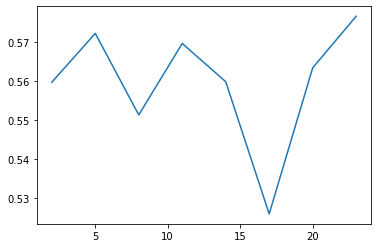

In [27]:
plt.plot(range(2, 25, 3), coherence_values)

In [28]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.015*"file" + 0.011*"program" + 0.009*"available" + 0.009*"files" + 0.009*"window" + 0.009*"image" + 0.008*"use" + 0.008*"version" + 0.008*"server" + 0.007*"set"'), (1, '0.036*"drive" + 0.015*"disk" + 0.015*"card" + 0.014*"chip" + 0.014*"drives" + 0.013*"MB" + 0.010*"mode" + 0.010*"serial" + 0.010*"controller" + 0.010*"bus"'), (2, '0.014*"people" + 0.013*"think" + 0.012*"know" + 0.008*"time" + 0.007*"good" + 0.007*"going" + 0.006*"right" + 0.006*"said" + 0.005*"way" + 0.005*"want"'), (3, '0.023*"game" + 0.022*"team" + 0.016*"play" + 0.016*"games" + 0.015*"year" + 0.013*"season" + 0.011*"players" + 0.009*"teams" + 0.008*"player" + 0.008*"hockey"'), (4, '0.010*"evidence" + 0.009*"believe" + 0.007*"true" + 0.007*"faith" + 0.006*"reason" + 0.005*"religion" + 0.005*"people" + 0.005*"question" + 0.005*"life" + 0.005*"truth"'), (5, '0.010*"people" + 0.007*"said" + 0.006*"gun" + 0.005*"government" + 0.005*"children" + 0.005*"Armenian" + 0.004*"killed" + 0.004*"war" + 0.004*"Israeli" + 0

In [ ]:
# The output of the LDA model can be interpreted as follows: 
# Output is a list where every element is a string. It only shows 10 most probable words for each topic. 
# Based on my output topic 0 contains 1.9% probability of containing word "entry", 1.6% probability of containing word "file", 
# 1.2% probability of containing word "program" etc. That is computed for all topics. 
# Every topic is a mix of all words in out vocabulary. The difference of the topics is that the probability is different. 
# Let's take the word "use" as an example. In topic 6 this word has a probability of 1.3%, while in topic in topic 8 for example, the probaility is 1.2%. 
# We can also print out the most important words for each topic, for example, for topic 4, the most important words are: key, encryption and chip.
# We can also interpret results using pyLDAvis. Each bubble represents a topic. Their location is based on the principal component space. 
# The larger the bubble the larger its percentage in all documents across all the entire corpus. 
# If we hover over one of the bubbles we can see the most important words in this particular topic.  
# We can also adjust the relevance of the words. If we move it closer to 0 and hover over one of the bubbles, 
# we can see the words that have high probability in that particular topic and low probability in the other topics. 
# Coherence values are higher when the selected topics represent the document really well or when the documents are well-proportion. 
# Too large number of topics or too low number of topics is not preferable. 

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling